Imports:

In [176]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, confusion_matrix
from torch.autograd import Function
import torch.nn.functional as F
from google.colab import drive, files
import json

# Download and Prepare Data

### Download Data

In [19]:
# Download the MNIST dataset and transform to Tensors
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Function to display grid of MNIST images

### MNIST Dataset

MNIST dataset is is a widely used benchmark for evaluating supervised learning image classification models, consisting of grey scale images of handwritten digits, zero through nine. It contains 60,000 images for training and 10,000 for testing. Each image is 28 x 28, with pixel values ranging from 0 (black) to 255 (white). Some images from the dataset can be seen below:

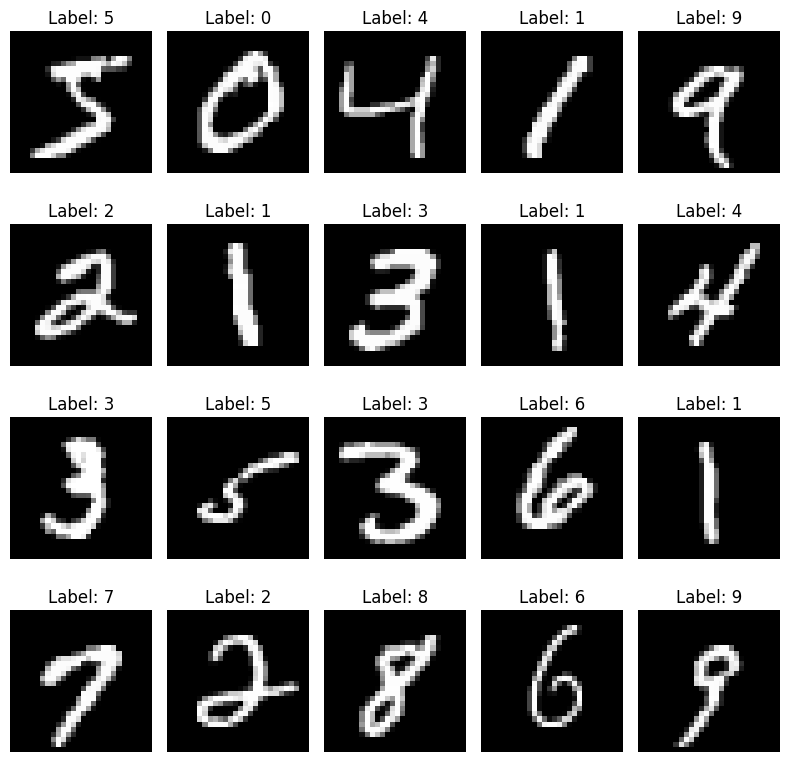

In [20]:
# Function to display grid of images
def show_mnist_grid(dataset, num_images=16, cols=4, title="Alex's MNIST Images"):
    rows = num_images // cols  # Calculate number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))  # Create subplots

    for i, ax in enumerate(axes.flat):
        image, label = dataset[i]  # Get image and label
        ax.imshow(image.squeeze(), cmap="gray")  # Display image
        ax.set_title(f"Label: {label}")  # Set title
        ax.axis("off")  # Remove axis

    plt.tight_layout()
    plt.show()

# Display 4 x 5 grid of MNIST images
show_mnist_grid(mnist_train, num_images=20, cols=5)

# Analyze Dataset

### Preprocess the Data

In [21]:
# Set colors for train/test sets for graphs
train_color = "#1f77b4"
test_color = "#ff7f0e"

## Class Distribution

In [22]:
# Calculate number of occurences of each digit
def class_counts(dataset):
    labels = dataset.targets if hasattr(dataset, 'targets') else dataset.labels
    class_counts = torch.bincount(labels, minlength=10)  # Get count of each digit (0-9)
    return class_counts

Function to create bar chart of class distribution among data, counting the number of occurrences for each digit.

In [23]:
def class_distribution(data, title, color="green"):
    # Get class counts
    class_count = class_counts(data)

    # Plot bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(range(10), class_count.numpy(), color=color, alpha=0.7)
    plt.xticks(range(10))
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show counts above bars
    for i, count in enumerate(class_count.numpy()):
        plt.text(i, count + 50, str(count), ha='center', fontsize=10)

    plt.show()

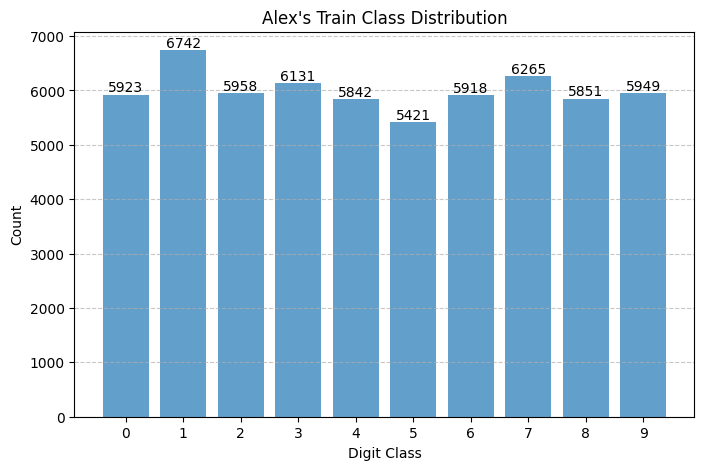

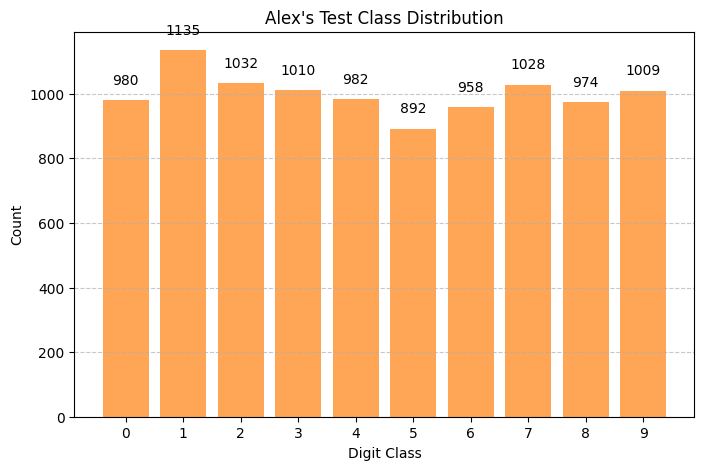

In [24]:
# Plot class distribution fo train and test dataset
class_distribution(mnist_train, "Alex's Train Class Distribution", train_color)
class_distribution(mnist_test, "Alex's Test Class Distribution", test_color)

In [25]:
# Compare class distribution of train and test datasets
def compare_distribution(data_train, data_test, title):
    # Get class counts for both train and test datasets
    class_counts_train = class_counts(data_train)
    class_counts_test = class_counts(data_test)

    # Calculate total number of samples in each dataset
    total_train = data_train.targets.size(0)  # Total samples in training set
    total_test = data_test.targets.size(0)    # Total samples in test set

    # Calculate percentages for each class
    percentages_train = class_counts_train.float() / total_train * 100
    percentages_test = class_counts_test.float() / total_test * 100

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    width = 0.35  # Bar width

    # Bar positions for each digit (adjusted to place bars side by side)
    x = range(10)

    # Plot bars for both train and test datasets
    plt.bar(x, percentages_train.numpy(), width, label="Train", color=train_color, alpha=0.7)
    plt.bar([p + width for p in x], percentages_test.numpy(), width, label="Test", color=test_color, alpha=0.7)

    # Customize the plot
    plt.xticks([p + width / 2 for p in x], range(10))  # Move xticks to the middle of the grouped bars
    plt.xlabel("Digit Class")
    plt.ylabel("Percentage (%)")
    plt.title(title)
    plt.legend()

    # Show counts above bars, avoid overlap
    for i in range(10):
        # Default position for train data
        train_label_y = percentages_train[i] + 1
        plt.text(i, train_label_y, f'{percentages_train[i]:.1f}%', ha='center', fontsize=10, color=train_color)

        # Position label for test data, avoiding overlap with train
        test_label_y = percentages_test[i] + 1

        # Check if test label overlaps with train label
        if abs(test_label_y - train_label_y) < 2:  # Threshold for overlap detection, feel free to adjust
            # Adjust test label position slightly above the train label
            test_label_y = train_label_y + 0.45

        plt.text(i + width, test_label_y, f'{percentages_test[i]:.1f}%', ha='center', fontsize=10, color=test_color)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



Comparison of what percentage of train/test datasets are made up of each digit

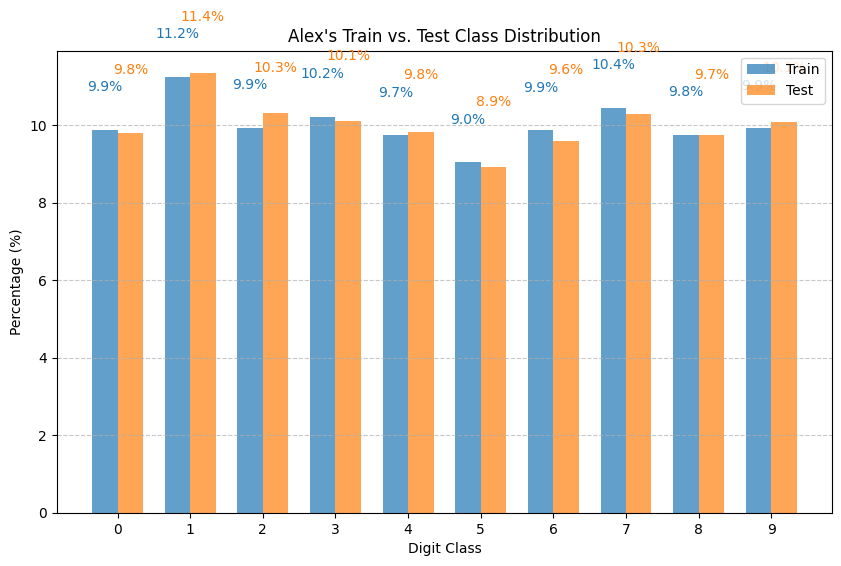

In [26]:
compare_distribution(mnist_train, mnist_test, "Alex's Train vs. Test Class Distribution")

## Pixel Heatmap

Function to create heatmap of each classes' pixels. Essentially shows average image of each digit

In [27]:
def pixel_heatmap(data_zip, title):
    # Organize images by digit class
    digit_means = {i: [] for i in range(10)}

    # Collect images for each digit
    for img, label in data_zip:
        digit_means[label.item()].append(img)

    # Compute average image per digit
    for digit in range(10):
        digit_means[digit] = torch.stack(digit_means[digit], dim=0).float().mean(dim=0)

    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for digit, ax in enumerate(axes.flat):
        sns.heatmap(digit_means[digit].numpy(), cmap="inferno", ax=ax, cbar=False)
        ax.set_title(f"Digit: {digit}")
        ax.axis("off")

    # Set Title
    plt.suptitle(title, fontsize=20, fontweight="bold")

    plt.tight_layout()
    plt.show()

### Training Set Heatmap

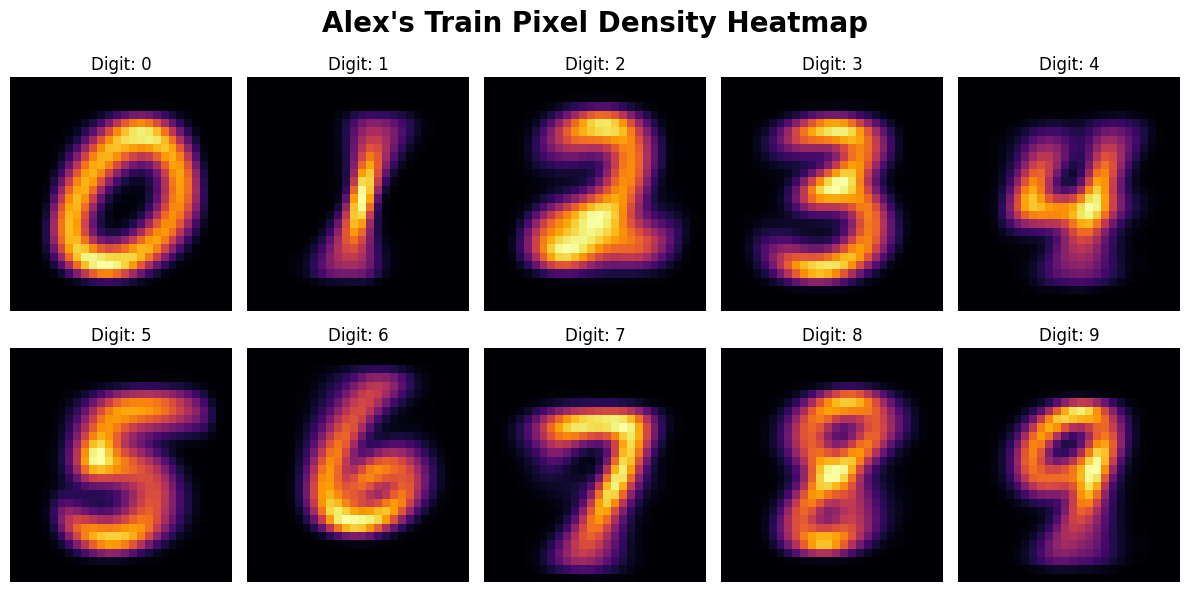

In [28]:
pixel_heatmap(zip(mnist_train.data, mnist_train.targets), "Alex's Train Pixel Density Heatmap")

### Testing Set Heatmap

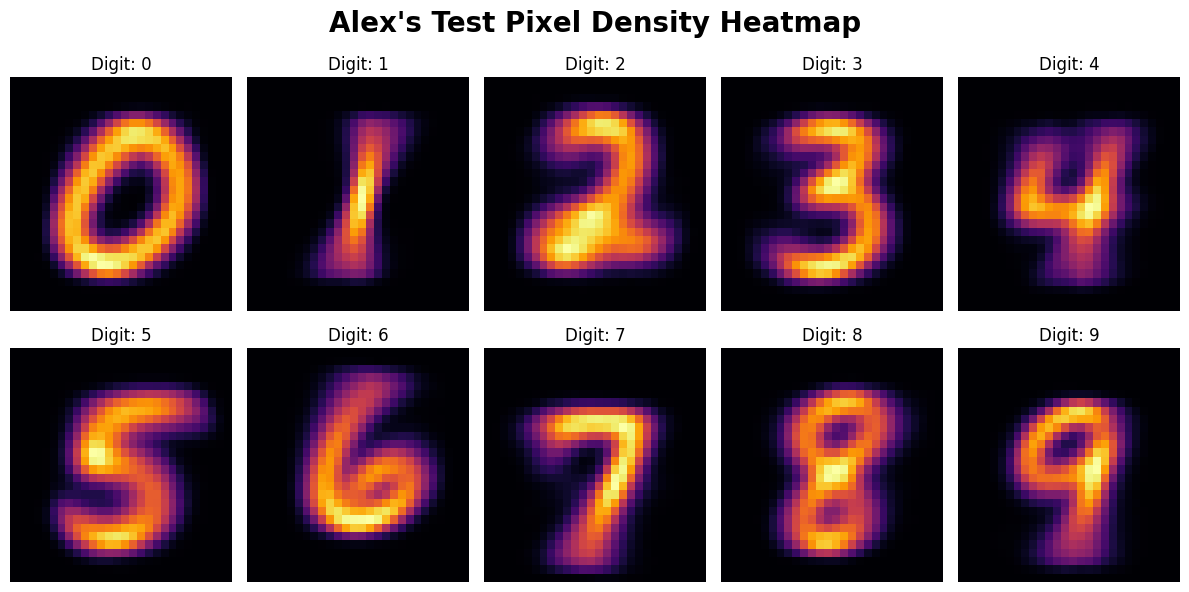

In [29]:
pixel_heatmap(zip(mnist_test.data, mnist_test.targets), "Alex's Test Pixel Density Heatmap")

## Preprocess the Data

Both training and test datasets are scaled from [0, 255] to [0, 1] when converted to tensor. Additionally, both sets are standardized to their *z*-scores, resulting in a mean of 0.137 and standard deviation of 0.3081. This helps the model to stabalize gradients and converge faster when learning, as well as reducing bias towards certain features. Each image in the training data set is rotated 10% in a random direction, in an attempt to help improve the models generalization and perfomance with skewed images.



In [30]:
# Normalize and randomly rotate train set. by 10%
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

In [31]:
# Normalize test set
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

## Transformed Images

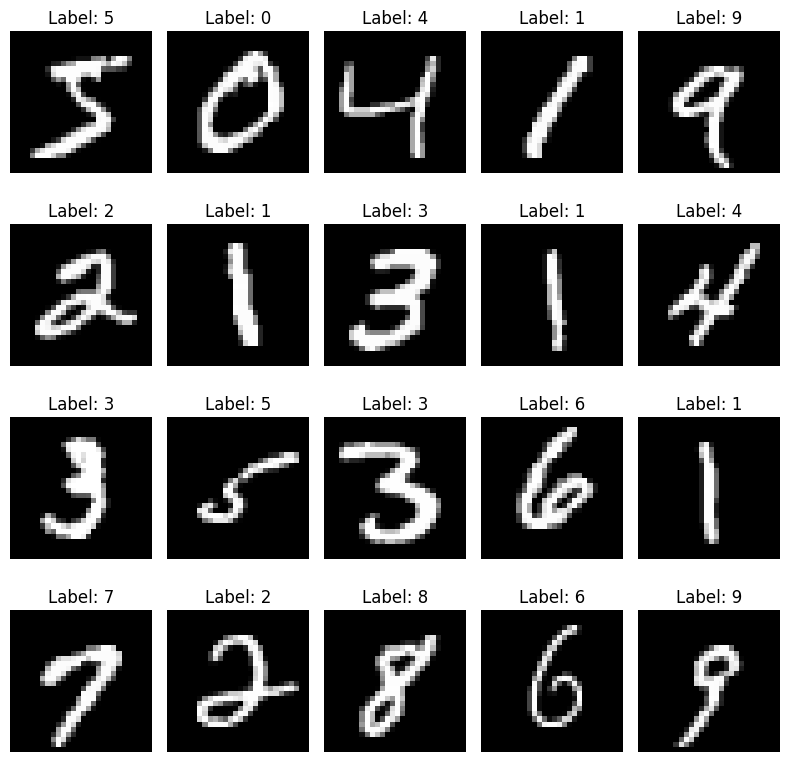

In [32]:
show_mnist_grid(mnist_train, num_images=20, cols=5)

### Save data to DataLoader

In [33]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

# Build CNN

### Network Architecture

In [34]:
class AlexBNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # First convolutional layer + BatchNorm
            nn.Conv2d(1, 32, (3, 3), padding=1),  # 1 input channel (grayscale), 32 output channels, kernel size 3x3
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Max Pooling (2x2) reduces dimensions by half

            # Second convolutional layer + BatchNorm
            nn.Conv2d(32, 64, (3, 3), padding=1),  # 32 input channels, 64 output channels, kernel size 3x3
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Max Pooling (2x2)

            # Third convolutional layer + BatchNorm
            nn.Conv2d(64, 128, (3, 3), padding=1),  # 64 input channels, 128 output channels
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Max Pooling (2x2)

            # Fully connected layers
            nn.Flatten(),  # Flatten the multi-dimensional output from the conv layers into a 1D vector
            nn.Linear(128 * 3 * 3, 128),  # Fully connected layer (128 * 3 * 3 comes from the spatial dimensions after pooling)
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer to prevent overfitting

            nn.Linear(128, 10)  # Final fully connected layer, output size is 10 (for MNIST classes 0-9)
        )

    def forward(self, x):
        return self.main(x)

# Define the model
model = AlexBNet()




## Prediction Methods

### Gets Predicted Probabilities

In [112]:
def predict_proba(self, dataloader, device="cpu"):
    """Returns predicted probabilities for a given dataloader."""
    self.eval()
    all_probs = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            logits = self.forward(images)
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


### Gets Predicted Class

In [36]:
def predict_class(self, dataloader, device="cpu"):
    """Returns predicted class indices by calling predict_proba."""
    probs = self.predict_proba(dataloader, device)
    return torch.argmax(probs, dim=1)  # Get the class with highest probability


Add Predictions to AlexBNet as class Methods

In [39]:
AlexBNet.predict_proba = predict_proba
AlexBNet.predict_class = predict_class

# Train the network

### Class to hold data from training

In [38]:
class TrainingMetrics:
    def __init__(self):
        # Loss per epoch
        self.train_loss = []
        self.test_loss = []

        # Accuracy per epoch
        self.train_acc = []
        self.test_acc = []

        #Learning rate per epoch
        self.learning_rates = []

        #Final results
        self.test_preds = []
        self.test_labels = []

    def append(self, train_loss, test_loss, train_acc, test_acc, learning_rate):
        self.train_loss.append(train_loss)
        self.test_loss.append(test_loss)
        self.train_acc.append(train_acc)
        self.test_acc.append(test_acc)
        self.learning_rates.append(learning_rate)

    def __repr__(self):
        return f"TrainingMetrics(train_loss={self.train_loss}, test_loss={self.test_loss}, train_acc={self.train_acc}, test_acc={self.test_acc}, learning_rates={self.learning_rates})"

    def get_epoch(self):
        return len(self.train_loss)

### Training Loop

In [40]:
def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs=30, verbose=True, metrics=None):
    # Initialize the metrics tracker
    if metrics is None:
        metrics = TrainingMetrics()

    starting_epoch = metrics.get_epoch()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for inputs, targets in train_loader:
            # Move data/labels to device
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the parameters

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        # Update the learning rate scheduler
        scheduler.step()

        # Compute training accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        # Check if last epoch
        last_epoch = (epoch == num_epochs - 1)

        with torch.no_grad():
            for inputs, targets in test_loader:
                # Move data/labels to device

                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute test loss
                running_test_loss += loss.item()

                # Calculate test accuracy
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == targets).sum().item()
                total_test += targets.size(0)

                # Log Prediction and Result
                if last_epoch:
                    metrics.test_preds.extend(predicted.cpu().numpy())
                    metrics.test_labels.extend(targets.cpu().numpy())

        # Compute test accuracy
        test_loss = running_test_loss / len(test_loader)
        test_acc = correct_test / total_test

        # Store the metrics for the current epoch
        metrics.append(train_loss, test_loss, train_acc, test_acc, scheduler.get_last_lr()[0])

        # Print metrics for this epoch
        if verbose:
            print(f'Epoch {epoch+1 + starting_epoch}/{num_epochs + starting_epoch}, '
                  f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
                  f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, '
                  f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

    # Join final results into single list:

    # Return the metrics object after training
    return metrics

### Use Adam Optimizer and CrossEntropyLoss Function

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

### Set Learning Rate Scheduler

In [42]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

### Move Data to GPU

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device: {device}")

Device: cuda


### AlexBNet Summary

In [44]:

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
      BatchNorm2d-10            [-1, 128, 7, 7]             256
             ReLU-11            [-1, 128, 7, 7]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                  [

### Train Model

In [45]:
metrics = train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs=30)

Epoch 1/30, Train Loss: 0.1865, Test Loss: 0.0417, Train Accuracy: 0.9458, Test Accuracy: 0.9852, Learning Rate: 0.001000
Epoch 2/30, Train Loss: 0.0758, Test Loss: 0.0702, Train Accuracy: 0.9785, Test Accuracy: 0.9774, Learning Rate: 0.001000
Epoch 3/30, Train Loss: 0.0588, Test Loss: 0.0300, Train Accuracy: 0.9833, Test Accuracy: 0.9903, Learning Rate: 0.001000
Epoch 4/30, Train Loss: 0.0524, Test Loss: 0.0256, Train Accuracy: 0.9849, Test Accuracy: 0.9919, Learning Rate: 0.001000
Epoch 5/30, Train Loss: 0.0487, Test Loss: 0.0433, Train Accuracy: 0.9862, Test Accuracy: 0.9878, Learning Rate: 0.001000
Epoch 6/30, Train Loss: 0.0438, Test Loss: 0.0398, Train Accuracy: 0.9870, Test Accuracy: 0.9886, Learning Rate: 0.001000
Epoch 7/30, Train Loss: 0.0417, Test Loss: 0.0218, Train Accuracy: 0.9878, Test Accuracy: 0.9926, Learning Rate: 0.001000
Epoch 8/30, Train Loss: 0.0416, Test Loss: 0.0406, Train Accuracy: 0.9879, Test Accuracy: 0.9870, Learning Rate: 0.001000
Epoch 9/30, Train Loss: 

### Save Model

Function to save model's current state to Collab's working directory

In [180]:
def save_model(model, optimizer, scheduler, file_path="model.pth"):
    # Create a dictionary to hold the model state, optimizer state, scheduler state, and metrics
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }

    # Save the checkpoint
    torch.save(checkpoint, file_path)
    print(f"Model saved to {file_path}")

Set up files to save to Google Drive

### Save file

In [178]:
# Mount Google Drive
drive.mount("/content/drive")

# Path in Google Drive where the model will be uploaded
drive_path = "/content/drive/MyDrive/AlexBNet/AlexBNet.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
# Download to Google Collab's working directory
file_path = "AlexBNet.pth"
save_model(model, optimizer, scheduler, file_path=file_path)

Model saved to AlexBNet.pth


In [158]:
# Check file exists in working directory
import os
os.listdir()

['.config', 'drive', 'data', 'AlexBNet.pth', 'sample_data']

In [163]:
# Download the saved model file from Google Collab to local PC
files.download("AlexBNet.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
# Save files to drive for redundency (little GPU time for training on free tier)
!cp AlexBNet.pth "{drive_path}"
print(f"Model uploaded to {drive_path}")

Model uploaded to /content/drive/MyDrive/AlexBNet/AlexBNet.pth


### Load Model and State

In [182]:
def load_model_and_metrics(model, optimizer, scheduler, file_path="model.pth", device="cpu"):
    # Load checkpoint
    checkpoint = torch.load(file_path, map_location=device)

    # Restore model, optimizer, and scheduler states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print(f"Model loaded from {file_path}")

    return model, optimizer, scheduler


# Analyze Model Performance

## Analyze for Over or Under Fitting

### Function to create plot of data over epoch

In [71]:
def plot_over_epoch(epochs, train_data, test_data, title, y_lbl):
    fig = go.Figure()

    # Add Train Loss
    fig.add_trace(go.Scatter(
        x=epochs,
        y=train_data,
        mode='lines+markers',
        name=f'Train {y_lbl}',
        line=dict(color=train_color),
        marker=dict(symbol="circle")
    ))

    # Add Test Loss
    fig.add_trace(go.Scatter(
        x=epochs,
        y=test_data,
        mode='lines+markers',
        name=f'Test {y_lbl}',
        line=dict(color=test_color),
        marker=dict(symbol="circle")
    ))

    # Customize layout
    fig.update_layout(
        title=title,
        xaxis_title="Epoch",
        yaxis_title=y_lbl,
        legend_title=f'{y_lbl} Type',
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

In [72]:
# Data for x-axis
epochs = list(range(1, metrics.get_epoch() + 1))

### Train Loss vs. Test Loss

In [73]:
plot_over_epoch(epochs, metrics.train_loss, metrics.test_loss, "Alex's Train vs. Test Loss", 'Loss')

This graphic shows the calculated loss over epoch for the training and the test datasets. The training loss continues to drop over all 30 epochs, while the test loss doesnt see any significant gains after about the 11th epoch. It is possible that this model has been overtrained.

#### Train Accuracy vs. Test Accuracy

In [74]:
plot_over_epoch(epochs, metrics.train_acc, metrics.test_acc, "Alex's Train vs. Test Accuracy", 'Accuracy')

After around 20 epochs, the test accuracy seems to level out.

## Confusion Matrix

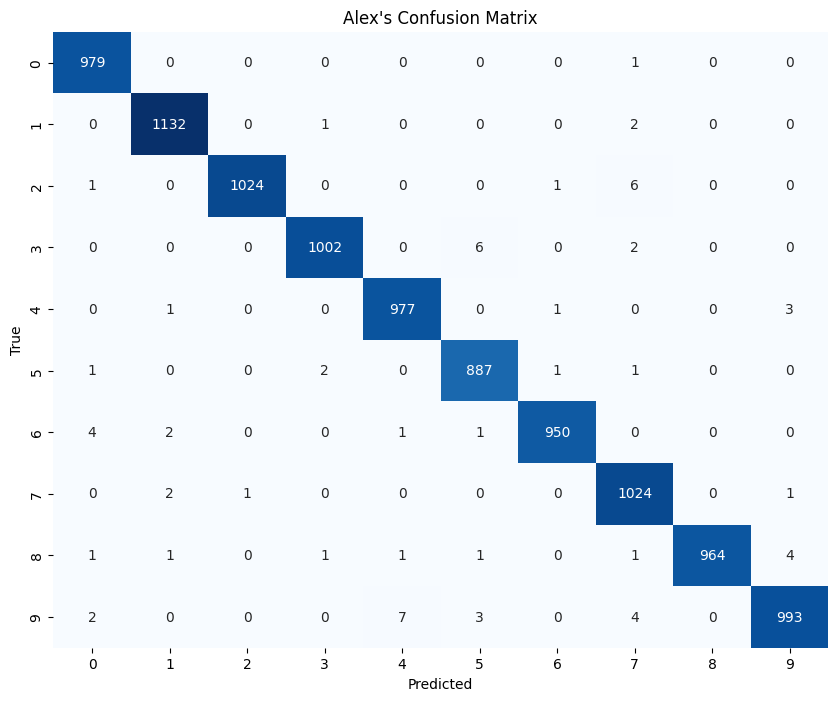

In [76]:
# Generate confusion matrix
cm = confusion_matrix(metrics.test_labels, metrics.test_preds)

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))

# Labels and title
plt.title("Alex's Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Show the plot
plt.show()

The confusion matrix shows each image's true class on the y-axis and the class predicted by the model on the x-axis. Certain numbers are more commonly predicted as certain classes more than others. For example, on 7 occasions, images of nine were predicted as 4. This makes sense, as 9 and 4 have similar shape. I am curious as to why 4 was only predicted as 9 once. This relationship was the most wrongly-predicted by the model. Many pairs of classes from the map have a similarly lopsided relationship, but to a lesser extent.

## Misclassified Images

Function to get list of misclassified images

In [77]:
def get_misclassified_images(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    misclassified_images = []
    misclassified_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Find misclassified samples
            misclassified_mask = predicted != targets
            if misclassified_mask.any():
                misclassified_images.append(inputs[misclassified_mask])
                misclassified_labels.append(predicted[misclassified_mask])

    # Concatenate all misclassified images and labels into single tensors
    if misclassified_images:
        misclassified_images = torch.cat(misclassified_images, dim=0)
        misclassified_labels = torch.cat(misclassified_labels, dim=0)
    else:
        misclassified_images = torch.tensor([])
        misclassified_labels = torch.tensor([])

    # Convert to NumPy format
    misclassified_images = [img.cpu().numpy().squeeze() for img in misclassified_images]
    misclassified_labels = misclassified_labels.cpu().numpy()

    # Return list of imag/label tuples
    return list(zip(misclassified_images, misclassified_labels))


Get misclassified images from test set

In [78]:
misclassified = get_misclassified_images(model, test_loader, device)

# Get number om misclassified images:
len(misclassified)

68

Display misclassified images and predicted labels

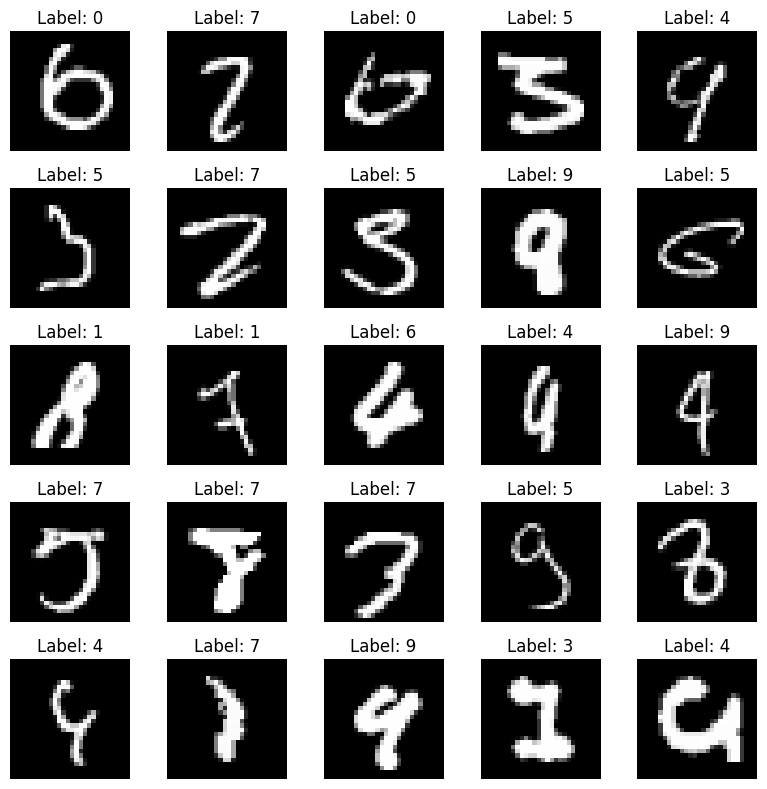

In [79]:
show_mnist_grid(misclassified, num_images=25, cols=5)

This graphic shows the first 25 (out of 65) incorrectly classified images from the test set, as well as the predicted class. Looking at these images, it is easy to see why they are missclassified, as even to the human eye, it can be hard to see which class they are really in.

## ROC Curve

Function to generate graph

In [86]:
def plot_roc_curve(probs, true_labels, title="ROC Curve"):
    # Compute ROC curve and AUC for each class
    fig = go.Figure()
    num_classes = probs.shape[1]

    # Create curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels == i, probs[:, i])
        auc_score = auc(fpr, tpr)

        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"Class {i} (AUC = {auc_score:.2f})"))

    # Plot diagonal baseline
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"), name="Random Guess"))

    # Layout settings
    fig.update_layout(
        title=title,
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        legend_title="Classes",
        template="plotly_white"
    )

    fig.show()

Get required data for roc curve

In [87]:
model.to(device)
probs = model.predict_proba(test_loader, device=device).cpu().numpy()
true_labels = torch.cat([y for _, y in test_loader]).cpu().numpy()

Get roc curve

In [88]:
plot_roc_curve(probs, true_labels, title="Alex's ROC curve")

The ROC curve generally demonstrates storng performance by the model. All classes follow the same general trend, but by zooming in on the top left of the curves, some differences can be found. Class 9 can be seen to have the weakest performance, which coincides with the data in the confusion matrix.

## Grad-CAM Heatmap

Grad-CAM heatmap detects which part of the input images are being used most heavily to classify the images

In [142]:
class GradCAM: # Class to create GradCAM images
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None
        self.hooks()

    def hooks(self):
        def save_feature_map(module, input, output):
            self.feature_maps = output.detach()

        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(save_feature_map)
        self.target_layer.register_backward_hook(save_gradients)

    def generate_cam(self, class_idx):
        # Make a forward pass to get feature maps
        self.model.zero_grad()
        output = self.model(self.input_image)

        # Backpropagate to get gradients
        output[0, class_idx].backward()

        # 1. Pool the gradients across the channels
        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3], keepdim=True)

        # 2. Weight the feature maps by the pooled gradients
        weighted_maps = self.feature_maps * pooled_grads

        # 3. Sum across the channels to get the final heatmap
        cam = weighted_maps.sum(dim=1, keepdim=True)

        # 4. Apply ReLU to the heatmap (to focus on positive importance)
        cam = F.relu(cam)

        # 5. Normalize the heatmap
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().cpu()  # Return as a Tensor,==

    def overlay_cam(self, image, cam): # Overlay GradCAM on image
        # Ensure image is in the correct shape (28, 28) for plotting
        image = image.squeeze().cpu().numpy()  # Remove batch dimension and move to numpy array

        # Ensure cam is a tensor before applying unsqueeze
        cam = cam.unsqueeze(0).unsqueeze(0)  # Convert back to tensor if it's not
        cam_resized = torch.nn.functional.interpolate(cam, size=(image.shape[0], image.shape[1]), mode='bilinear', align_corners=False)
        cam_resized = cam_resized.squeeze().cpu().numpy()

        # Plot the image and the heatmap
        plt.imshow(image, cmap='gray')
        plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay heatmap
        plt.colorbar()
        plt.show()

    def get_gradcam(self, image, class_idx): # Wrapper function for getting GradCAM
        self.input_image = image  # Assign the test image to self.input_image
        cam = self.generate_cam(class_idx)
        self.overlay_cam(image, cam)

Function to produce Grad-CAM for specified number of images

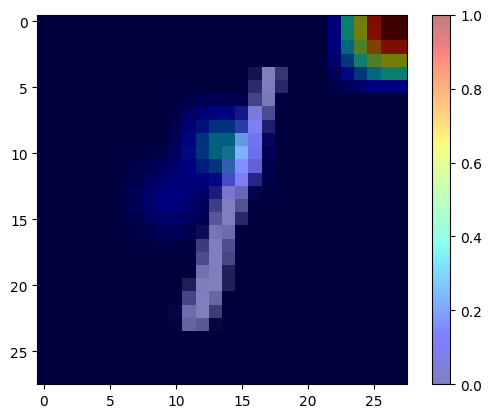

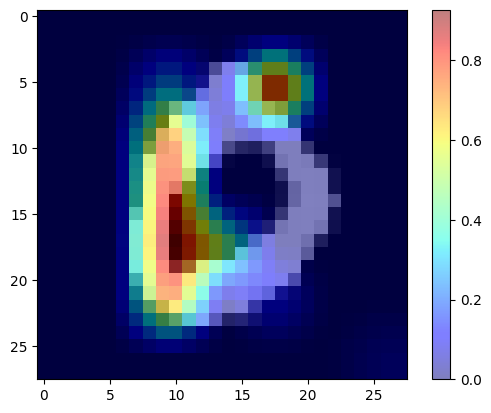

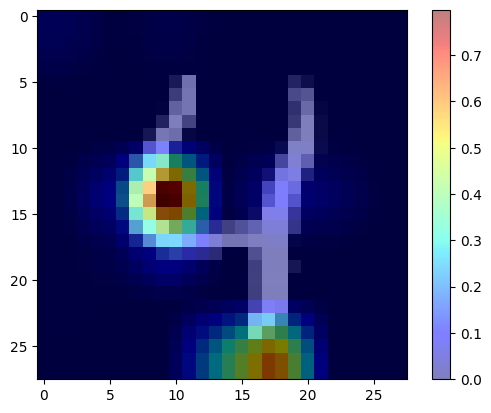

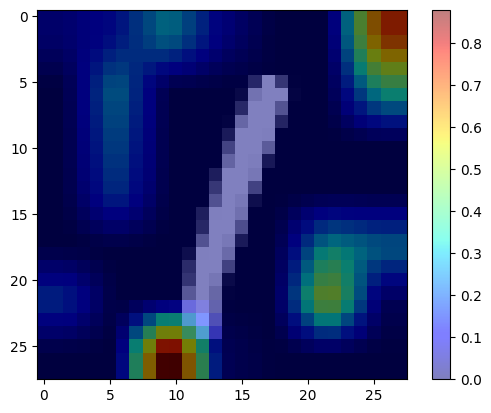

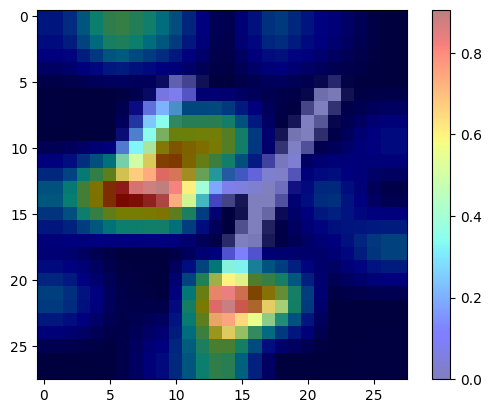

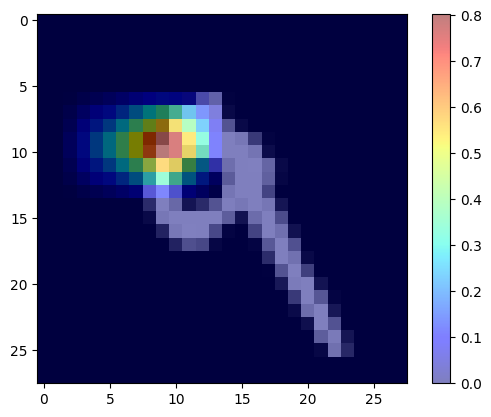

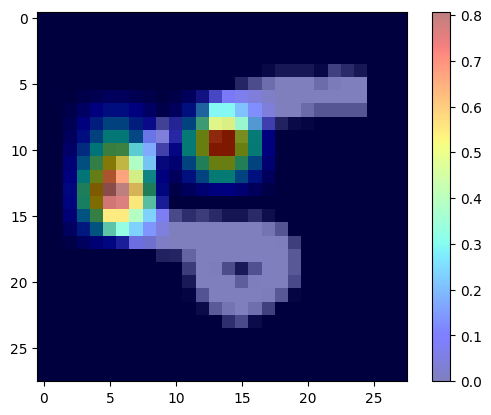

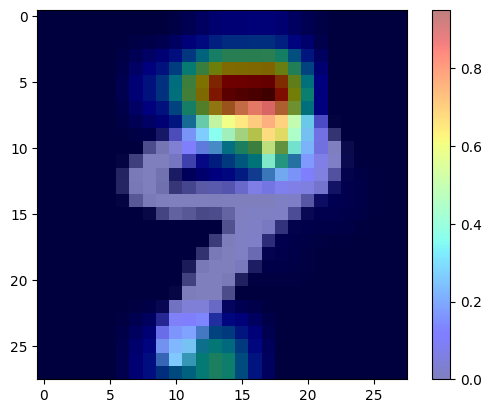

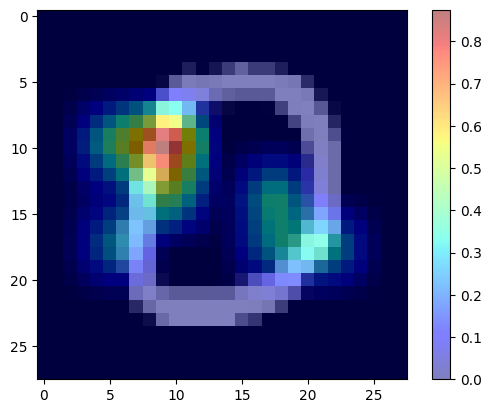

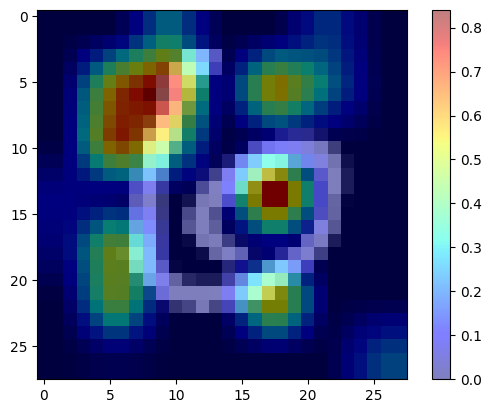

In [148]:
def display_gradcam_for_multiple_images(model, target_layer, num_images, dataset, device):
    # Initialize the GradCAM class
    grad_cam = GradCAM(model, target_layer)

    # Loop through the specified number of images
    for i in range(num_images):
        # Load the test image
        test_image, _ = dataset[i+2]  # Select the i-th image from the dataset

        # Preprocess the image (since it's already in Tensor format, no need to apply ToTensor)
        test_image = test_image.unsqueeze(0)  # Add batch dimension: (1, 28, 28) -> (1, 1, 28, 28)
        test_image = test_image.to(device)  # Move the image to the same device as the model

                # Get the model's predicted class index
        output = model(test_image)
        predicted_class = torch.argmax(output, dim=1).item()  # Get the index of the max logit

        # Generate and overlay the Grad-CAM heatmap for this image
        grad_cam.get_gradcam(test_image, class_idx)

# Define the target layer, which is typically the last convolutional layer
target_layer = model.main[8]  # The third convolutional layer: Conv2d(64, 128, (3, 3), padding=1)

# Call the function with the desired number of images to display (e.g., 5 images)
num_images = 10
display_gradcam_for_multiple_images(model, target_layer, num_images, mnist_test, device)

The Grad-Cam shows that in general, the model focuses on the digits in the image during classification. However, I notice that for class one, the model seems to also focus on the edges of the image. By adjusting the *num_image* variable in the above cell, it can be observed that this trend continues throughout the dataset. This raises the possibility that additional random augmentation to the training set could be benifficial. I wonder if the model has noticed a pattern that class one images generally do not extend to the edges of the images as much as other digits. Random shifting or noise applied to the background may force the model to learn fromt he digit itself rather then the location. Despite the model incorreclty predicting class 1 images on only 3 occasions, it incorrectly predicted images as class 1 on 6. It is possible that for the images incorrectly predicted as class 1 were based off of horixantal location of the digit.

